# Analyze SARS-CoV-2 Strain B.1.1.7
[Work in progress]

This notebook queries the Knowledge Graph for Strains with the B.1.1.7 lineage.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
from matplotlib.dates import MonthLocator, WeekdayLocator
import seaborn as sns
from py2neo import Graph
import plotly.express as px

In [2]:
pd.options.display.max_rows = None  # display all rows
pd.options.display.max_columns = None  # display all columsns

##### Connect to COVID-19-Community Knowledge Graph

In [3]:
graph = Graph("bolt://132.249.238.185:7687", user="reader", password="demo")

##### Utility Methods

In [4]:
def transform_data(df, region):
    # calculate cummulatve sum
    df['total'] = df.groupby([region])['count'].cumsum()
    
    # pivot table
    df = pd.DataFrame(df.pivot(index='collectionDate', columns=region, values='total').to_records())
    df.fillna(method='ffill', inplace=True)
    
    # convert neo4j date to date
    df['collectionDate'] = df['collectionDate'].astype(str)
    df['collectionDate'] = pd.to_datetime(df['collectionDate'], infer_datetime_format=False)
    df.set_index('collectionDate', inplace=True)
    
    return df

In [5]:
def plot_time_series(df, title):
    plt.figure(figsize=(16, 10))
    ax = sns.lineplot(data=df);
    ax.set_title(title)
    ax.set_xlabel('Collection Date')
    ax.set_ylabel('Number of Strains')
    ax.set_yscale('log');
    ax.xaxis.set_major_locator(MonthLocator())
    ax.xaxis.set_minor_locator(WeekdayLocator())
    ax.tick_params(which='major', length=12)
    ax.tick_params(which='minor', length=8)
    ax.xaxis.grid(True, which='minor')
    ax.grid(True)

## Get Number of B.1.1.7 Strains with variant info

In [6]:
lineage = 'B.1.1.7'
taxonomy_id = 'taxonomy:2697049' # SARS-CoV-2

In [7]:
query = """
MATCH (s:Strain)
WHERE s.lineage = $lineage AND s.taxonomyId = $taxonomy_id
RETURN count(s) AS count
"""
n_strains = graph.evaluate(query, lineage=lineage, taxonomy_id=taxonomy_id)

In [8]:
print('Number of B.1.1.7 strains:', n_strains)

Number of B.1.1.7 strains: 67415


## Strain B.1.1.7 Time Series by UN Subregion

In [9]:
query = """
// aggregate data to the country level (City->Admin2->Admin1->County->UNIntermediateRegion->UNSubRegion): max 5 hops
MATCH (s:Strain)-[:FOUND_IN]->(:Location)-[:IN*0..5]->(u:UNSubRegion)
WHERE s.lineage = $lineage AND s.taxonomyId = $taxonomy_id
      AND s.collectionDate > date('2020-02-01') // remove strain with invalid collection date
RETURN DISTINCT(s.collectionDate) AS collectionDate, u.name AS subregion, count(s) AS count
ORDER BY collectionDate
"""
df_subregion = graph.run(query, lineage=lineage, taxonomy_id=taxonomy_id).to_data_frame()

In [10]:
df_subregion = transform_data(df_subregion, 'subregion')

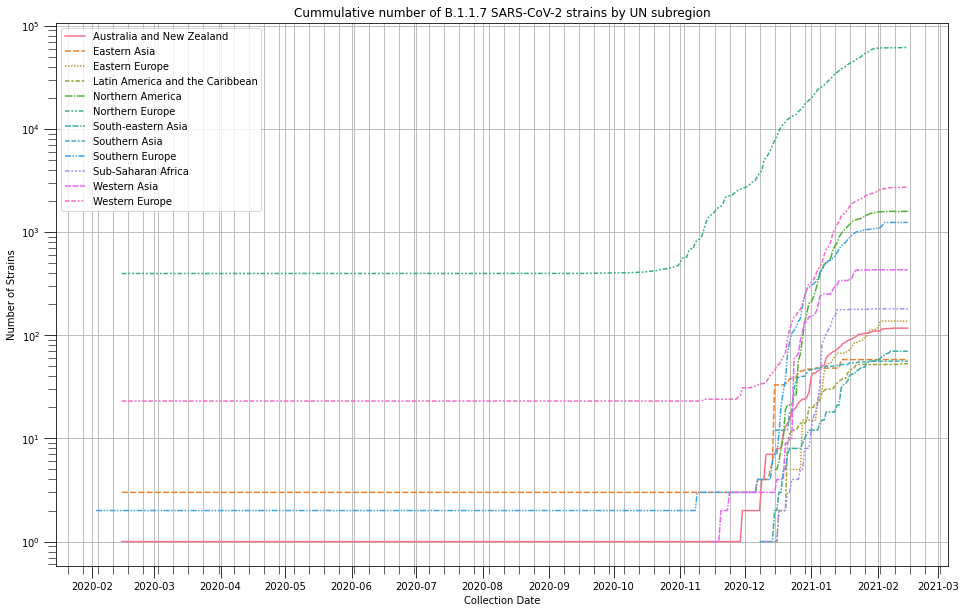

In [11]:
plot_time_series(df_subregion, f'Cummulative number of {lineage} SARS-CoV-2 strains by UN subregion')

## Strain B.1.1.7 Time Series by Country

In [12]:
query = """
// aggregate data to the country level (City->Admin2->Admin1->County): max 3 hops
MATCH (s:Strain)-[:FOUND_IN]->(:Location)-[:IN*0..3]->(c:Country)
WHERE s.lineage = $lineage AND s.taxonomyId = $taxonomy_id
      AND s.collectionDate > date('2020-02-01') // remove strain with invalid collection date
RETURN DISTINCT(s.collectionDate) AS collectionDate, c.name AS country, count(s) AS count
ORDER BY collectionDate
"""
df_country = graph.run(query, lineage=lineage, taxonomy_id=taxonomy_id).to_data_frame()

In [13]:
df_country = transform_data(df_country, 'country')

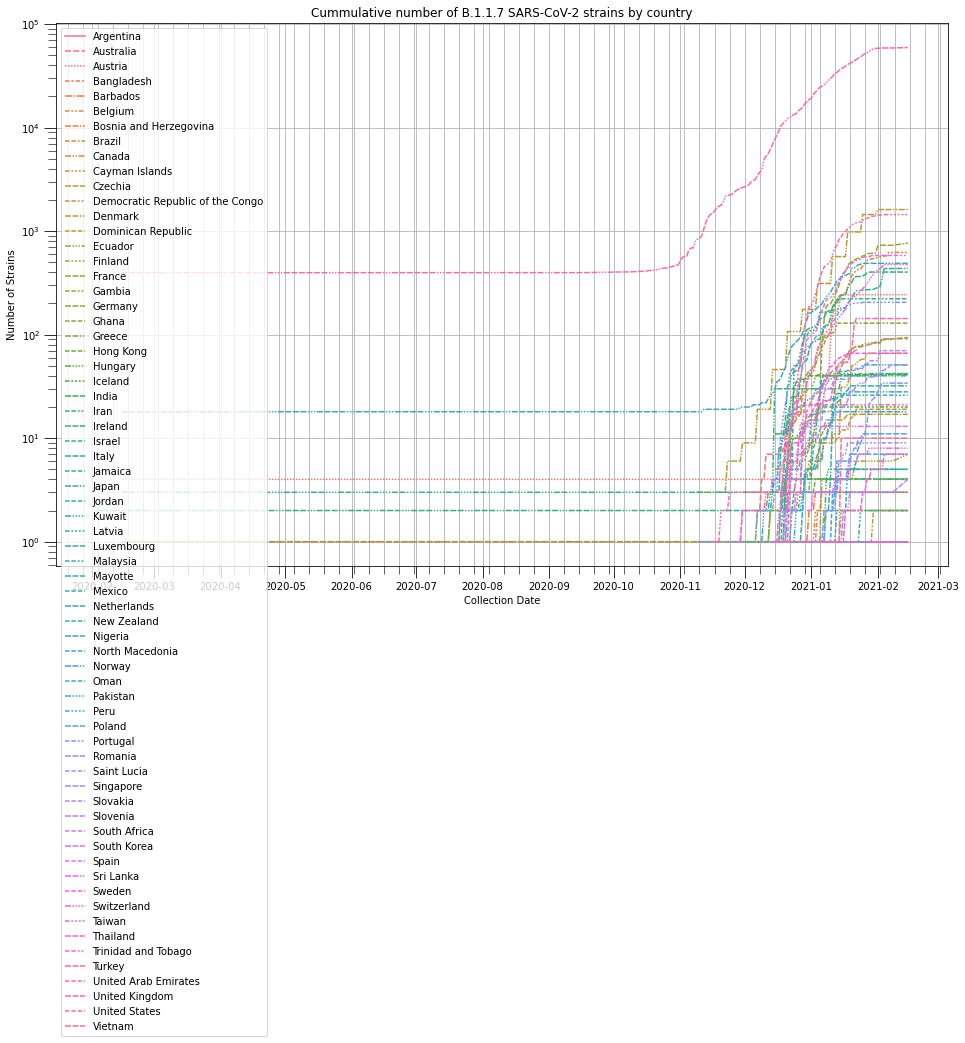

In [14]:
plot_time_series(df_country, f'Cummulative number of {lineage} SARS-CoV-2 strains by country')

## Strains B.1.1.7 by Country

In [30]:
query = """
// aggregate data to the country level (City->Admin2->Admin1->County): max 3 hops
MATCH (s:Strain)-[:FOUND_IN]->(:Location)-[:IN*0..3]->(c:Country)
WHERE s.lineage = $lineage AND s.taxonomyId = $taxonomy_id
      AND s.collectionDate > date('2020-02-01') // remove strain with invalid collection date
RETURN c.name AS country, c.iso3 as iso3, count(s) AS count
ORDER BY count DESC
"""
df_country_strains = graph.run(query, lineage=lineage, taxonomy_id=taxonomy_id).to_data_frame()

In [31]:
df_country_strains.head()

,country,iso3,count
0,United Kingdom,GBR,59279
1,Denmark,DNK,1614
2,United States,USA,1443
3,France,FRA,766
4,Belgium,BEL,622


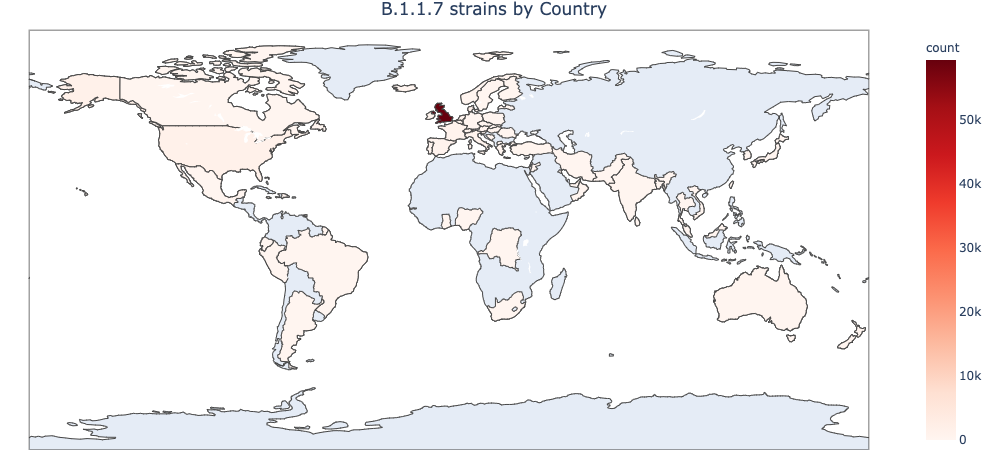

In [45]:
# TODO set log scale
fig = px.choropleth(df_country_strains, locations="iso3",
                    color="count",
                    hover_name="country",
                    hover_data=['count'],
                    color_continuous_scale=px.colors.sequential.Reds
                   )
fig.update_layout(
    title_text = f'{lineage} strains by Country',
    title_x=0.5,
    margin={"r":0,"l":0,"t":30,"b":0}
)
fig.show()

### Strain B.1.1.7 Time Series by State
Note, data reported at the country level will not be included here.

In [18]:
query = """
// aggregate data to the state (Admin1) level: (City->Admin2->Admin1): max 2 hops
MATCH (s:Strain)-[:FOUND_IN]->(:Location)-[:IN*0..2]->(a:Admin1)-[:IN]->(c:Country)
WHERE s.lineage = $lineage AND s.taxonomyId = $taxonomy_id 
      AND s.collectionDate > date('2020-02-01') // remove strain with invalid collection date
RETURN DISTINCT(s.collectionDate) AS collectionDate, c.iso3 + '-' + a.name AS state, a.name, c.name, count(s) AS count
ORDER BY collectionDate
"""
df_state = graph.run(query, lineage=lineage, taxonomy_id=taxonomy_id).to_data_frame()

In [19]:
df_state = transform_data(df_state, 'state')

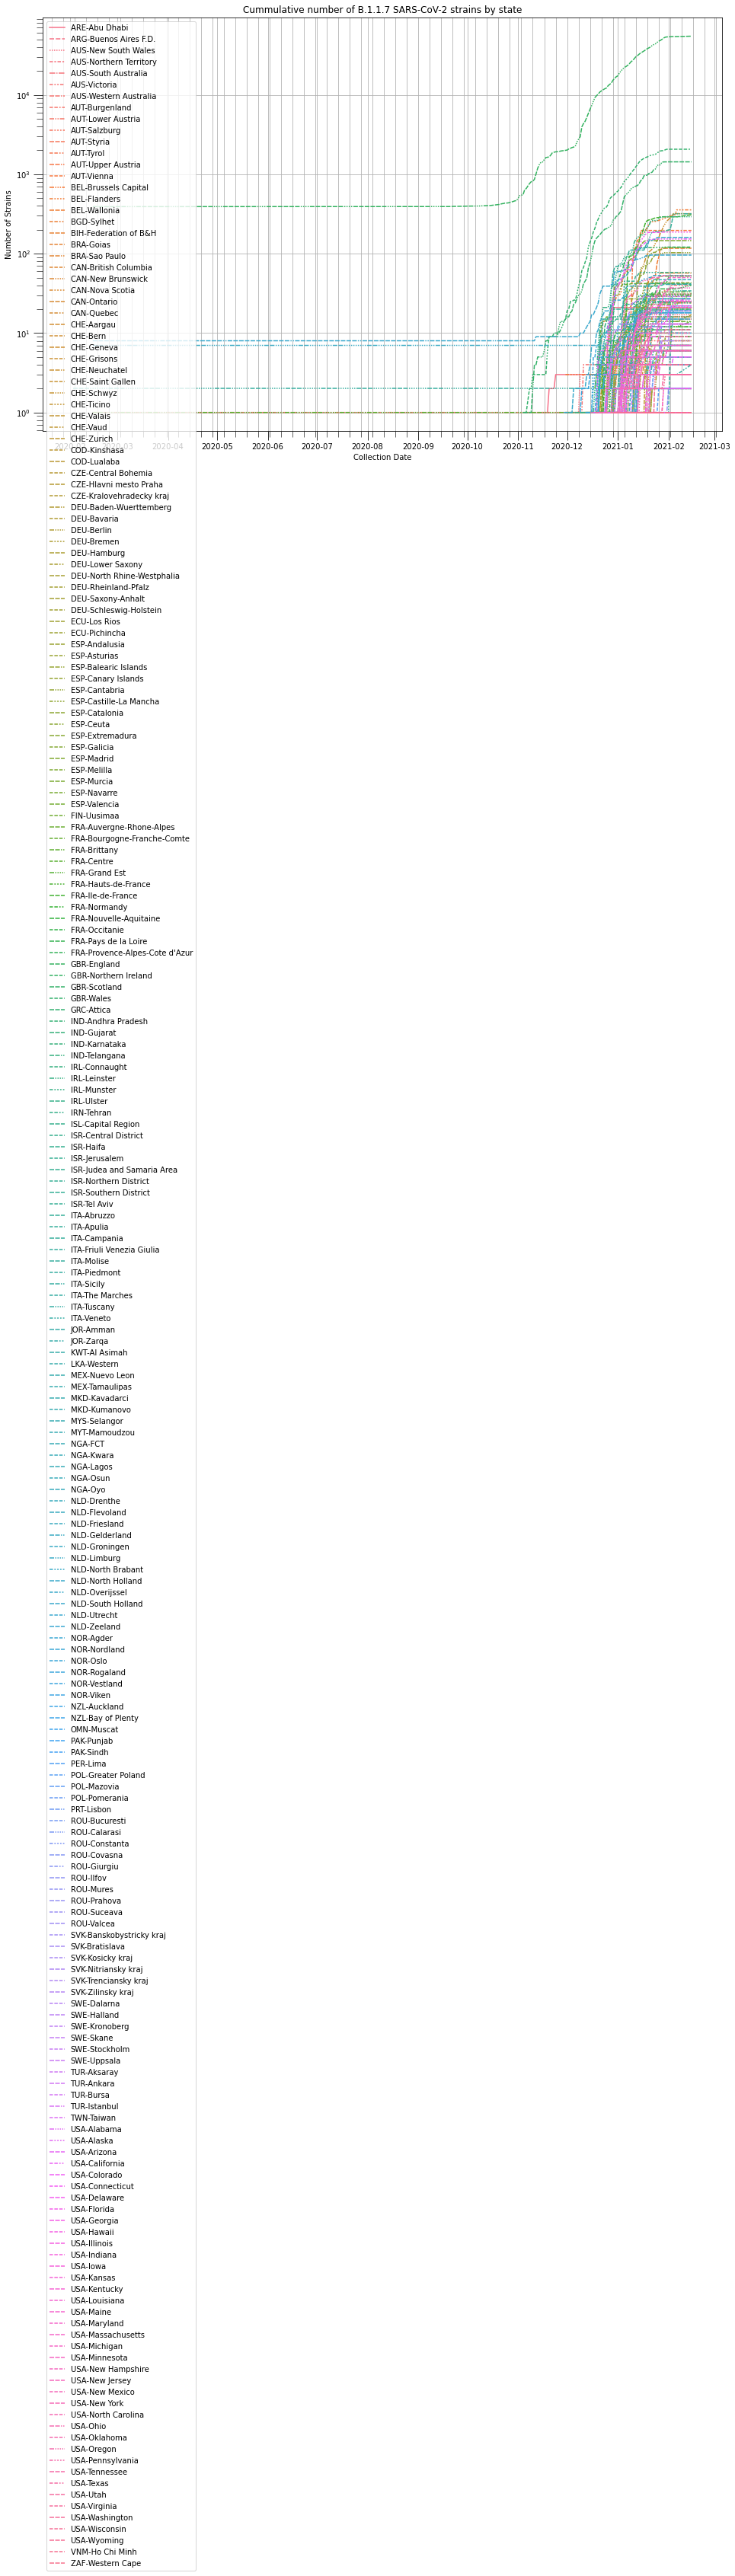

In [20]:
plot_time_series(df_state, f'Cummulative number of {lineage} SARS-CoV-2 strains by state')

## Strain B.1.1.7 Variant Frequencies

In [21]:
query = """
MATCH (s:Strain)-[:HAS_VARIANT]->(v:Variant)
WHERE s.lineage = $lineage AND s.taxonomyId = $taxonomy_id
RETURN DISTINCT(v.geneVariant) AS geneVariant, split(v.geneVariant, ':')[0] AS gene,
       v.proteinVariant AS proteinVariant, toString(v.proteinPosition) as proteinPosition, 
       v.variantConsequence AS variantConsequense, v.variantType AS variantType, 
       v.start AS start, count(s) AS count
ORDER BY count DESC, start ASC
"""
df_var = graph.run(query, lineage=lineage, taxonomy_id=taxonomy_id).to_data_frame()

In [22]:
df_var['frequency'] = df_var['count'] / n_strains

In [23]:
# TODO add menu: gene, proteinPosition, variantConsequence, variantType

In [24]:
df_var.head(30)

,geneVariant,gene,proteinVariant,proteinPosition,variantConsequense,variantType,start,count,frequency
0,S:c.1841gAt>gGt,S,S:p.614D>G,614,missense_variant,SNP,23403,50225,0.745012
1,ORF1ab:c.2772ttC>ttT,ORF1ab,QHD43415.1:p.924F,924,synonymous_variant,SNP,3037,50220,0.744938
2,ORF1ab:c.14144cCt>cTt,ORF1ab,QHD43415.1:p.4715P>L,4715,missense_variant,SNP,14408,50214,0.744849
3,ORF1ab:c.14412ccC>ccT,ORF1ab,ORF1ab:p.4804P,4804,synonymous_variant,SNP,14676,50213,0.744834
4,S:c.1501Aat>Tat,S,S:p.501N>Y,501,missense_variant,SNP,23063,50212,0.744819
5,S:c.2147aCa>aTa,S,S:p.716T>I,716,missense_variant,SNP,23709,50212,0.744819
6,S:c.2944Tca>Gca,S,S:p.982S>A,982,missense_variant,SNP,24506,50211,0.744805
7,S:c.1709gCt>gAt,S,S:p.570A>D,570,missense_variant,SNP,23271,50210,0.744790
8,ORF1ab,ORF1ab,QHD43415.1,None,upstream_gene_variant,SNP,241,50205,0.744716
9,ORF1ab:c.15015caC>caT,ORF1ab,QHD43415.1:p.5005H,5005,synonymous_variant,SNP,15279,50205,0.744716
